# Plot wind data vertical modes in mixed layer

About 50 km north of Barkley Canyon

In [2]:
# import modules

import xarray as xr
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as pldates
import scipy.signal as sig
import scipy.misc as deriv
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
for i in range(2):
    %matplotlib notebook

In [3]:
# import data

ds = xr.open_dataset(f'../../../Data/wind/wind.nc')
#print(ds)
    
N2_array = np.load('../N2/buoyancy_array.npy')
N2_depths = N2_array[0]                                 # depths range from -4 to -924 metres
N2_values = N2_array[1]
depth = np.linspace(0,980,981)
N2_int = np.interp(depth,-N2_depths,N2_values)

In [4]:
# select data

site = 'Slope'
year = 2013
t_stamp = f'{year}'
start_date = np.datetime64(f'{year}-01-01')
end_date = np.datetime64(f'{year+1}-01-01')

if year == 2013:
    dt_tot = ds.dt2013
    wdir_tot = ds.wdir2013
    wspd_tot = ds.wspd2013
elif year == 2014:
    dt_tot = ds.dt2014
    wdir_tot = ds.wdir2014
    wspd_tot = ds.wspd2014
elif year == 2017:
    dt_tot = ds.dt2017
    wdir_tot = ds.wdir2017
    wspd_tot = ds.wspd2017
elif year == 2018:
    dt_tot = ds.dt2018
    wdir_tot = ds.wdir2018
    wspd_tot = ds.wspd2018

In [5]:
# get data segments in lists

if year == 2013:
    dt0 = dt_tot[:]
    dt = [dt0]
    wspd0 = wspd_tot[:]
    wspd = [wspd0]
    wdir0 = wdir_tot[:]
    wdir = [wdir0]
    n_seg_wind = 1
elif year == 2014:
    dt0 = dt_tot[:621]
    dt1 = dt_tot[621:]
    dt = [dt0,dt1]
    wspd0 = wspd_tot[:621]
    wspd1 = wspd_tot[621:]
    wspd = [wspd0,wspd1]
    wdir0 = wdir_tot[:621]
    wdir1 = wdir_tot[621:]
    wdir = [wdir0,wdir1]
    n_seg_wind = 2
elif year == 2017:
    dt0 = dt_tot[:3974]
    dt1 = dt_tot[4100:5017]
    dt2 = dt_tot[5080:]
    dt = [dt0,dt1,dt2]
    wspd0 = wspd_tot[:3974]
    wspd1 = wspd_tot[4100:5017]
    wspd2 = wspd_tot[5080:]
    wspd = [wspd0,wspd1,wspd2]
    wdir0 = wdir_tot[:3974]
    wdir1 = wdir_tot[4100:5017]
    wdir2 = wdir_tot[5080:]
    wdir = [wdir0,wdir1,wdir2]
    n_seg_wind = 3
elif year == 2018:
    dt0 = dt_tot[:]
    dt = [dt0]
    wspd0 = wspd_tot[:]
    wspd = [wspd0]
    wdir0 = wdir_tot[:]
    wdir = [wdir0]
    n_seg_wind = 1

## Vertical mode decomposition (outlined by Jody, Alford, Zhen, etc.)

In [6]:
# get horizontal mixed layer velocity components

# import data

ds_in = xr.open_dataset(f'../../../Data/wind/ml_currents_{year}_0.nc')

n_seg = ds_in.n_seg
if n_seg > 1:
    dsw = [ds_in]
    for i in range(n_seg):
        if i > 0:
            dsw_temp = xr.open_dataset(f'../../../Data/wind/ml_currents_{year}_{i}.nc')
            dsw.append(dsw_temp)
elif n_seg == 1:
    dsw = [ds_in]

In [7]:
# vertical near-inertial energy transfer parameters

Nmix = 2.52e-3        # base of mixed layer N [Hz]
cor = 1.74e-5         # local Coriolis parameter [Hz]
#L = 400               # length scale, from paper (in km???)
roh = 1024            # avg density of mixed layer seawater from N2 calculations (similar for either season)
D = []
for i in range(n_seg):
    Dtemp = dsw[i].H.values             # depth of mixed layer through time
    D.append(Dtemp)

In [8]:
# band pass around f

ubp,vbp = [],[]   # empty lists for filtered data
fs = 2.777e-4                               # samples per SECOND for entire time series
Wn = [1.55e-5,2.00e-5]                      # cut-off frequencies
sos = sig.butter(8, Wn,'bandpass', fs=fs, output='sos')   # digital butterworth filter
w,h = sig.sosfreqz(sos) 
#plt.semilogx(w*fs/(2*np.pi),abs(h))

# component NI velocities
for i in range(n_seg):
    ufilt = np.copy(dsw[i].Zu.values)       # copy unfiltered array
    ubp_temp = sig.sosfiltfilt(sos, ufilt)  # apply band pass filter
    vfilt = np.copy(dsw[i].Zv.values)       # repeat for v
    vbp_temp = sig.sosfiltfilt(sos, vfilt)
    ubp.append(ubp_temp)
    vbp.append(vbp_temp)

# magnitude NI velocities
U = []
for i in range(n_seg):
    U.append(np.sqrt(ubp[i]**2 + vbp[i]**2))

In [9]:
# jody function for vertical modes

from matplotlib import pylab

def vertModes(N2,dz,nmodes=0): 
    """" psi,phi,ce,z=vertModes(N2,dz,nmodes=0)
    
    Compute the vertical eigen modes of the internal wave solution on a flat bottom
    
    Parameters:
    ----------- 
    N2 : (M) is buoyancy frequency squared (rad^2/s^2) as an 1-D
         array.  If there are M values of N2, the first one is assumed
         to be at dz/2 deep, and the last one is H-dz/2 deep.  The
         water column is assumed to be H=M*dz deep.  No gaps are
         allowed, and N2>0 everywhere.       
    dz : is a single value, and the distance (in meters) between the N2 estimates
    nmodes : number of modes to return.  nmodes = 0 means return M-3 modes.
            
         
    Returns:
    --------
    psi : (M,M-2) is the vertical structure function at
         z=dz/2,3dz/2,2dz...,H-dz/2.  Note there is one extra value
         compared to N2 (ie there are M+1 values in depth). psi is
         normalized so that sum(psi^2 dz) = 1.  For internal waves,
         psi is approriate for velocity and pressure vertical
         structure.          
    phi : (M,M-2) is the vertical integral of psi (phi = int psi dz)
         and represents the vertical velocity structure.  It is
         interpolated onto the same grid as psi.
    ce : (M-2) is the non-rotating phase speed of the waves in m/s.
    z :  (M) is the vertical position of the psi and phi vector elements.
             
    Notes: 
    ------
    This solves 1/N**2 psi_{zz} + (1/ce**2)psi = 0 subject to a
    boundary condition of zero vertical velocity at the surface and
    seafloor.
  
    psi(0)=0 (rigid lid approx)
    psi(H)=0
    
    It is solved as an eigenvalue problem.  
    Also note that if 
             
    J. Klymak (Based on code by Sam Kelly and Gabe Vecchi)           
    """

    import numpy as np
    
    # First we are solving for w on dz,2dz,3dz...H-dz
    M = np.shape(N2)[0]-1
        
    if M>200:
        sparse = True
        if nmodes==0:
            nmodes = 100 # don't try too many eigenvectors in sparse mode...
    else:
        sparse = False
        if nmodes==0:
            nmodes = M-2
    
    N2mid = N2[:-1]+np.diff(N2)/2.
    # matrix for second difference operator
    D = np.diag(-2.*np.ones(M),0)
    D += np.diag(1.*np.ones(M-1),-1)
    D += np.diag(1.*np.ones(M-1),1)

    D=-D/dz/dz
    D = np.diag(1./N2mid).dot(D)
    ce,W = np.linalg.eig(D)
    # psi is such that sum(psi^2)=1 but we want sum(psi^2 dz)=1.
    W = W/np.sqrt(dz)
    ce = 1./np.sqrt(ce)
    ind=np.argsort(-ce)
    
    ce=ce[ind[:-2]]
    W=W[:,ind[:-2]]
    # zphi
    zphi = np.linspace(dz/2.,((M+1)*dz)-(dz/2.),M+1)

    # now get phi (w structure) on dz/2,3dz/2...
    phi = np.zeros((M+1,M+1-3))
    phi[0,:]=0.5*(W[0,:])
    phi[1:-1,:]=0.5*(W[:-1,:]+W[1:,:])
    phi[-1,:]=0.5*(W[-1,:])
    
    # Now get psi (u/p structure) on dz/2,3dz/2...
    psi = np.zeros((M+1,M+1-3))
    psi[0,:] = W[0,:]
    psi[1:-1,] = np.diff(W,axis=0)
    psi[-1,:] = -W[-1,:]
    
    A = np.sqrt(np.sum(psi*psi,axis=0)*dz)
    psi = psi/A
    phi = phi/A
    # flip sign so always same sign in psi at top:
    phi[:,psi[0,:]<0] *= -1
    psi[:,psi[0,:]<0] *= -1

    return psi,phi,ce,zphi

In [10]:
# jody code for vertical modes

if site == 'Slope':
    vertD = len(N2_depths[0:378])
elif site == 'Axis':
    vertD = len(N2_depths[0:968])
    
L = vertD                                     # vertical segment scale (want every depth?)
#Nsq = np.full(L,0)                           # N2 array
Nsq = N2_int[0:vertD]
dz = 1                                        # vertical space between N2 values
c = np.sqrt(Nsq)*L/np.pi                      # mode phase speed
z0 = np.linspace(0,vertD,L)                   # depth array
# these are the "meshpoints" for w.
dz = np.median(np.diff(z0))  
z = z0[:-1]+dz/2.  # these are midpoints.     # get mid-points of depths

#Nsq = ((2.52e-3)**2) * np.exp(-z / vertD.)    # redefine N2 through depth
#Nsq = Nsq*0.+5.2e-3**2
c = np.mean(np.sqrt(Nsq))*L/np.pi          # average c through depth

psi,phi,ce,zph = vertModes(Nsq,dz)             # get vertical mode data (psi is at )

print("c theory: %1.4f c[0]: %1.4f"%(c,ce[0]))

for i in range(4):
    print('int psi 0 psi %d:  %1.2e'%(i,np.sum(psi[:,0]*psi[:,i]*dz)))
for i in range(4):
    print('int Nsq phi 0 phi %d (normalised):  %1.2e'%(i,np.sum(phi[:,0]*phi[:,i]*Nsq*dz)/np.sum(phi[:,0]*phi[:,0]*Nsq*dz)))

# fig,axs=plt.subplots(1,2,figsize=(8,6))
# for nn in range(5):
#     axs[0].plot(psi[:,nn],-zph)
#     axs[1].plot(phi[:,nn],-zph)
# axs[0].set_ylabel('Depth [m]')
# axs[0].set_xlabel('$\phi$: horizontal structure')
# axs[1].set_xlabel('$\psi$: vertical structure')

c theory: 0.9585 c[0]: 0.9869
int psi 0 psi 0:  1.00e+00
int psi 0 psi 1:  1.32e-11
int psi 0 psi 2:  9.80e-12
int psi 0 psi 3:  5.90e-12
int Nsq phi 0 phi 0 (normalised):  1.00e+00
int Nsq phi 0 phi 1 (normalised):  -2.34e-05
int Nsq phi 0 phi 2 (normalised):  -3.75e-06
int Nsq phi 0 phi 3 (normalised):  -9.41e-07


<IPython.core.display.Javascript object>


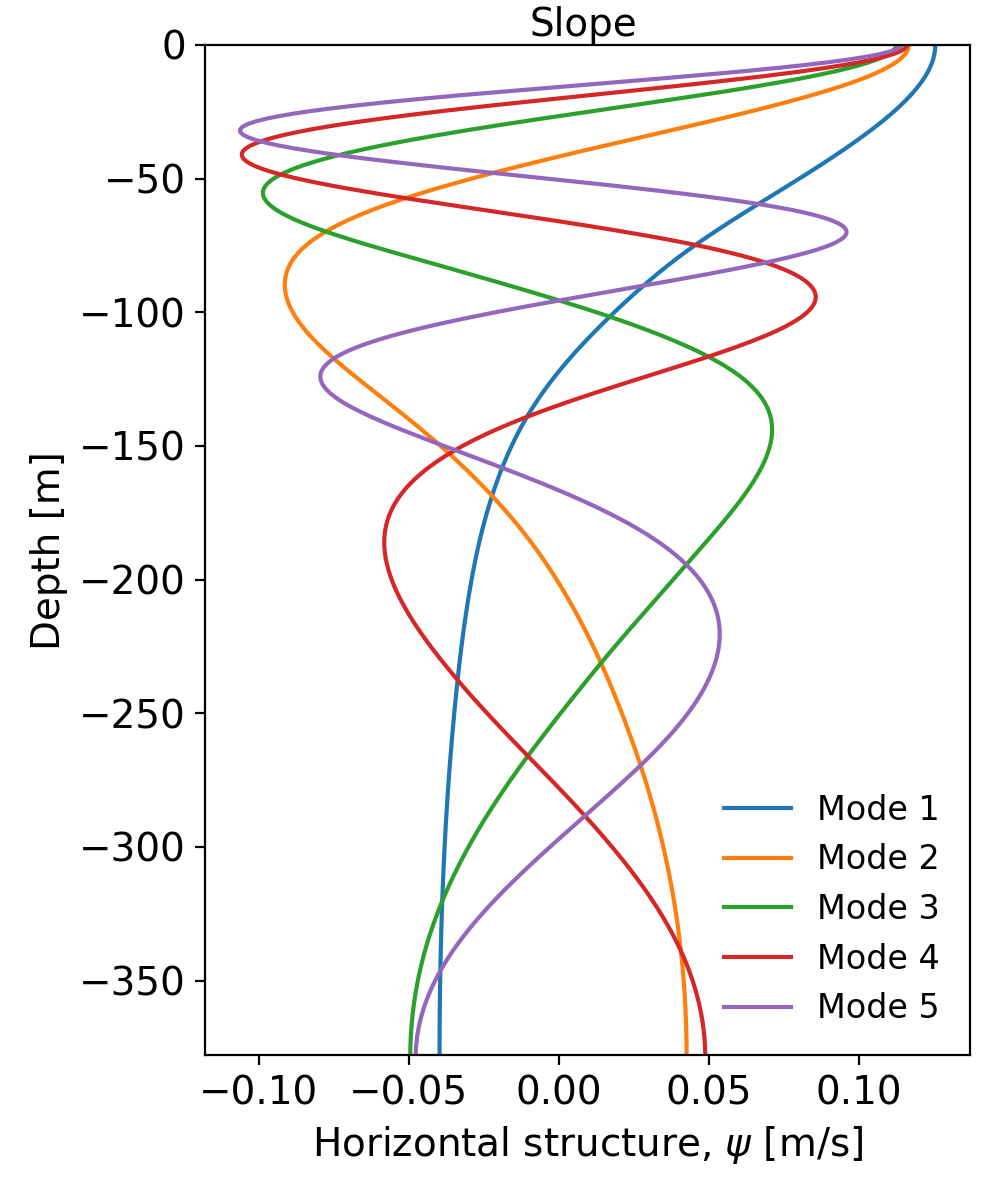

In [11]:
# plot modes

fig,ax=plt.subplots(1,1,figsize=(5,6))

# ax.plot(psi[:,0]/abs(np.max(psi[:,0])),-zph,label='mode 1')
# ax.plot(psi[:,1]/abs(np.max(psi[:,0])),-zph,label='mode 2')
# ax.plot(psi[:,2]/abs(np.max(psi[:,0])),-zph,label='mode 3')
# ax.plot(psi[:,3]/abs(np.max(psi[:,0])),-zph,label='mode 4')
# ax.plot(psi[:,4]/abs(np.max(psi[:,0])),-zph,label='mode 5')
ax.plot(psi[:,0],-zph,label='Mode 1')
ax.plot(psi[:,1],-zph,label='Mode 2')
ax.plot(psi[:,2],-zph,label='Mode 3')
ax.plot(psi[:,3],-zph,label='Mode 4')
ax.plot(psi[:,4],-zph,label='Mode 5')

ax.set_ylabel('Depth [m]',fontsize=14)
fig.text(0.53,0.97,f'{site}',fontsize=14)
#axs[0].set_xlabel('$\phi$: horizontal structure')
ax.set_xlabel('Horizontal structure, $\psi$ [m/s]',fontsize=14)
ax.set_ylim(-vertD,0)
ax.tick_params(labelsize=14)
ax.legend(fontsize=12,frameon=False)
fig.tight_layout()

# plt.savefig(fname=f'./vertmodes_{site}.pdf',format='pdf')

In [12]:
# modal depth influence

mode1_20 = np.sum(psi[0:21,0])
mode2_20 = np.sum(psi[0:21,1])
mode3_20 = np.sum(psi[0:21,2])
mode4_20 = np.sum(psi[0:21,3])
mode5_20 = np.sum(psi[0:21,4])
modes_20 = abs(mode1_20) + abs(mode2_20) + abs(mode3_20) + abs(mode4_20) + abs(mode5_20)

print('Mode 1 (20 m):',mode1_20,'(',(abs(mode1_20) / modes_20),')')
print('Mode 2 (20 m):',mode2_20,'(',(abs(mode2_20) / modes_20),')')
print('Mode 3 (20 m):',mode3_20,'(',(abs(mode3_20) / modes_20),')')
print('Mode 4 (20 m):',mode4_20,'(',(abs(mode4_20) / modes_20),')')
print('Mode 5 (20 m):',mode5_20,'(',(abs(mode5_20) / modes_20),')')
print('--------------')

mode1_60 = np.sum(psi[0:61,0])
mode2_60 = np.sum(psi[0:61,1])
mode3_60 = np.sum(psi[0:61,2])
mode4_60 = np.sum(psi[0:61,3])
mode5_60 = np.sum(psi[0:61,4])
modes_60 = abs(mode1_60) + abs(mode2_60) + abs(mode3_60) + abs(mode4_60) + abs(mode5_60)

print('Mode 1 (60 m):',mode1_60,'(',(abs(mode1_60) / modes_60),')')
print('Mode 2 (60 m):',mode2_60,'(',(abs(mode2_60) / modes_60),')')
print('Mode 3 (60 m):',mode3_60,'(',(abs(mode3_60) / modes_60),')')
print('Mode 4 (60 m):',mode4_60,'(',(abs(mode4_60) / modes_60),')')
print('Mode 5 (60 m):',mode5_60,'(',(abs(mode5_60) / modes_60),')')

Mode 1 (20 m): 2.561145577242509 ( 0.2881441304627852 )
Mode 2 (20 m): 2.1568606778092083 ( 0.24265967153879617 )
Mode 3 (20 m): 1.7612902729953546 ( 0.19815564515907774 )
Mode 4 (20 m): 1.4391654367913085 ( 0.16191468265650258 )
Mode 5 (20 m): 0.9699563872171711 ( 0.10912587018283823 )
--------------
Mode 1 (60 m): 6.220421669475102 ( 0.5432357311137589 )
Mode 2 (60 m): 2.329576150155746 ( 0.20344424708780554 )
Mode 3 (60 m): -0.5640370969299412 ( 0.04925793153695867 )
Mode 4 (60 m): -1.5539135460389748 ( 0.1357048454468019 )
Mode 5 (60 m): -0.7827373321689246 ( 0.068357244814675 )


In [13]:
# generate seasonal modal .nc data

mode1 = psi[:,0]   # mode eigenfunctions
mode2 = psi[:,1]
mode3 = psi[:,2]
mode4 = psi[:,3]
mode5 = psi[:,4]
mode_depths = zph  # mode depths

uf,vf,Uf = ubp,vbp,U     # near-inertial slab currents (u, v, and amplitude U)

mld,time = D,[]
for i in range(n_seg):
    time_temp = dsw[i].time.values             # depth of mixed layer and time
    time.append(time_temp)

# save data to .nc for modal comparison
modes = []
for i in range(n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            uf=(['time'], uf[i]),        
            vf=(['time'], vf[i]),
            Uf=(['time'], Uf[i]),
            mld=(['time'], mld[i]),
            mode1=(['depth'], mode1),
            mode2=(['depth'], mode2),
            mode3=(['depth'], mode3),
            mode4=(['depth'], mode4),
            mode5=(['depth'], mode5),
        ),
        coords=dict(
            depth=mode_depths,           # depth values for modes
            time=time[i],           # datetime values in segments
        ),
        attrs=dict(
            description=f'Vertical mode data for {site} {year} segment {i} (from 0 to {n_seg - 1}).',
            site=site,                   # adcp
            #upidx=upidx,                 # upper depth index
            #lowidx=lowidx,               # lower depth index
            #dup_stamp=dup_stamp,         # upper depth stamp
            #dlow_stamp=dlow_stamp,       # lower depth stamp
            #t_stamp=t_stamp,             # year stamp
            #start_date=f'{start_date}',  # start date
            #end_date=f'{end_date}',      # end date
            #t=t,                         # length of time series
            #d=d,                         # length of depth series
            n_seg=n_seg,                 # total number of segments
        ),
    ) 
    ds_out.to_netcdf(f'./modes_{site}_{year}_{i}.nc')
    modes.append(ds_out)

In [14]:
# find seasonal modal amplitudes

Z1,Z2,Z3,Z4,Z5 = [],[],[],[],[]
for i in range(modes[0].n_seg):
    U = modes[i].uf.values + (modes[i].vf.values*1j)  # total complex near-inertial mixed-layer currents
    #d = len(modes[i].depth.values)             # modal depth
    tmode = len(modes[i].time.values)              # number of time steps in segment

    Z1x,Z2x,Z3x,Z4x,Z5x = [],[],[],[],[]
    for j in range(tmode):
        mld_temp = int(modes[i].mld[j].values)
        Z1x.append(np.sum(U[j] * modes[i].mode1[0:mld_temp+1].values))
        Z2x.append(np.sum(U[j] * modes[i].mode2[0:mld_temp+1].values))
        Z3x.append(np.sum(U[j] * modes[i].mode3[0:mld_temp+1].values))
        Z4x.append(np.sum(U[j] * modes[i].mode4[0:mld_temp+1].values))
        Z5x.append(np.sum(U[j] * modes[i].mode5[0:mld_temp+1].values))
    Z1.append(Z1x)
    Z2.append(Z2x)
    Z3.append(Z3x)
    Z4.append(Z4x)
    Z5.append(Z5x)

In [15]:
# get modal amplitudes

Z1_amp,Z2_amp,Z3_amp,Z4_amp,Z5_amp = [],[],[],[],[]
Z1_real,Z2_real,Z3_real,Z4_real,Z5_real = [],[],[],[],[]
Z1_imag,Z2_imag,Z3_imag,Z4_imag,Z5_imag = [],[],[],[],[]
for i in range(modes[0].n_seg):
    Z1_amp.append(np.sqrt(np.real(Z1[i])**2 + np.imag(Z1[i])**2))
    Z2_amp.append(np.sqrt(np.real(Z2[i])**2 + np.imag(Z2[i])**2))
    Z3_amp.append(np.sqrt(np.real(Z3[i])**2 + np.imag(Z3[i])**2))
    Z4_amp.append(np.sqrt(np.real(Z4[i])**2 + np.imag(Z4[i])**2))
    Z5_amp.append(np.sqrt(np.real(Z5[i])**2 + np.imag(Z5[i])**2))
    Z1_real.append(np.real(Z1[i]))
    Z2_real.append(np.real(Z2[i]))
    Z3_real.append(np.real(Z3[i]))
    Z4_real.append(np.real(Z4[i]))
    Z5_real.append(np.real(Z5[i]))
    Z1_imag.append(np.imag(Z1[i]))
    Z2_imag.append(np.imag(Z2[i]))
    Z3_imag.append(np.imag(Z3[i]))
    Z4_imag.append(np.imag(Z4[i]))
    Z5_imag.append(np.imag(Z5[i]))

In [16]:
# save data to .nc for modal comparisons

mode_amp = []
for i in range(modes[0].n_seg):
    ds_out = xr.Dataset( 
        data_vars=dict(
            Z1_real=(['time'], Z1_real[i]),
            Z2_real=(['time'], Z2_real[i]),
            Z3_real=(['time'], Z3_real[i]),
            Z4_real=(['time'], Z4_real[i]),
            Z5_real=(['time'], Z5_real[i]),
            Z1_imag=(['time'], Z1_imag[i]),
            Z2_imag=(['time'], Z2_imag[i]),
            Z3_imag=(['time'], Z3_imag[i]),
            Z4_imag=(['time'], Z4_imag[i]),
            Z5_imag=(['time'], Z5_imag[i]),
            Z1_amp=(['time'], Z1_amp[i]),
            Z2_amp=(['time'], Z2_amp[i]),
            Z3_amp=(['time'], Z3_amp[i]),
            Z4_amp=(['time'], Z4_amp[i]),
            Z5_amp=(['time'], Z5_amp[i]),
        ),
        coords=dict(
            time=time[i],           # datetime values in segments
        ),
        attrs=dict(
            description=f'Modal amplitudes for {site} {year} segment {i} (from 0 to {n_seg - 1}).',
            site=site,                    # adcp
            #upidx=upidx,                 # upper depth index
            #lowidx=lowidx,               # lower depth index
            #dup_stamp=dup_stamp,         # upper depth stamp
            #dlow_stamp=dlow_stamp,       # lower depth stamp
            #t_stamp=t_stamp,             # year stamp
            #start_date=f'{start_date}',  # start date
            #end_date=f'{end_date}',      # end date
            #t=t,                         # length of time series
            #d=d,                         # length of depth series
            n_seg=n_seg,                  # total number of segments
        ),
    ) 
    ds_out.to_netcdf(f'./mode_amp_{site}_{year}_{i}.nc')
    mode_amp.append(ds_out)

In [17]:
# load other site mode data

if site == 'Slope':
    site2 = 'Axis'
elif site == 'Axis':
    site2 = 'Slope'
    
ds_in = xr.open_dataset(f'./mode_amp_{site2}_{year}_0.nc')
mode_amp2 = [ds_in]
n_seg_site2 = ds_in.n_seg
if n_seg_site2 > 1:
    for i in range(n_seg_site2):
        if i > 0:
            mode_amp2_temp = xr.open_dataset(f'./mode_amp_{site2}_{year}_{i}.nc')
            mode_amp2.append(mode_amp2_temp)

ds_in = xr.open_dataset(f'./modes_{site2}_{year}_0.nc')
modes2 = [ds_in]
n_seg_modes2 = ds_in.n_seg
if n_seg_modes2 > 1:
    for i in range(n_seg_modes2):
        if i > 0:
            modes2_temp = xr.open_dataset(f'./modes_{site2}_{year}_{i}.nc')
            modes2.append(modes2_temp)

In [18]:
# coarsen mode amplitude data

Z1c,Z2c,Z3c,Z4c,Z5c = [],[],[],[],[]
Ufc = []
for i in range(mode_amp[0].n_seg):
    Z1c.append(mode_amp[i].Z1_amp.coarsen(time=24,boundary='trim').mean())
    Z2c.append(mode_amp[i].Z2_amp.coarsen(time=24,boundary='trim').mean())
    Z3c.append(mode_amp[i].Z3_amp.coarsen(time=24,boundary='trim').mean())
    Z4c.append(mode_amp[i].Z4_amp.coarsen(time=24,boundary='trim').mean())
    Z5c.append(mode_amp[i].Z5_amp.coarsen(time=24,boundary='trim').mean())
    Ufc.append(modes[i].Uf.coarsen(time=24,boundary='trim').mean())
    
Z1c2,Z2c2,Z3c2,Z4c2,Z5c2 = [],[],[],[],[]
Ufc2 = []
for i in range(mode_amp2[0].n_seg):
    Z1c2.append(mode_amp2[i].Z1_amp.coarsen(time=24,boundary='trim').mean())
    Z2c2.append(mode_amp2[i].Z2_amp.coarsen(time=24,boundary='trim').mean())
    Z3c2.append(mode_amp2[i].Z3_amp.coarsen(time=24,boundary='trim').mean())
    Z4c2.append(mode_amp2[i].Z4_amp.coarsen(time=24,boundary='trim').mean())
    Z5c2.append(mode_amp2[i].Z5_amp.coarsen(time=24,boundary='trim').mean())
    Ufc2.append(modes2[i].Uf.coarsen(time=24,boundary='trim').mean())

<IPython.core.display.Javascript object>


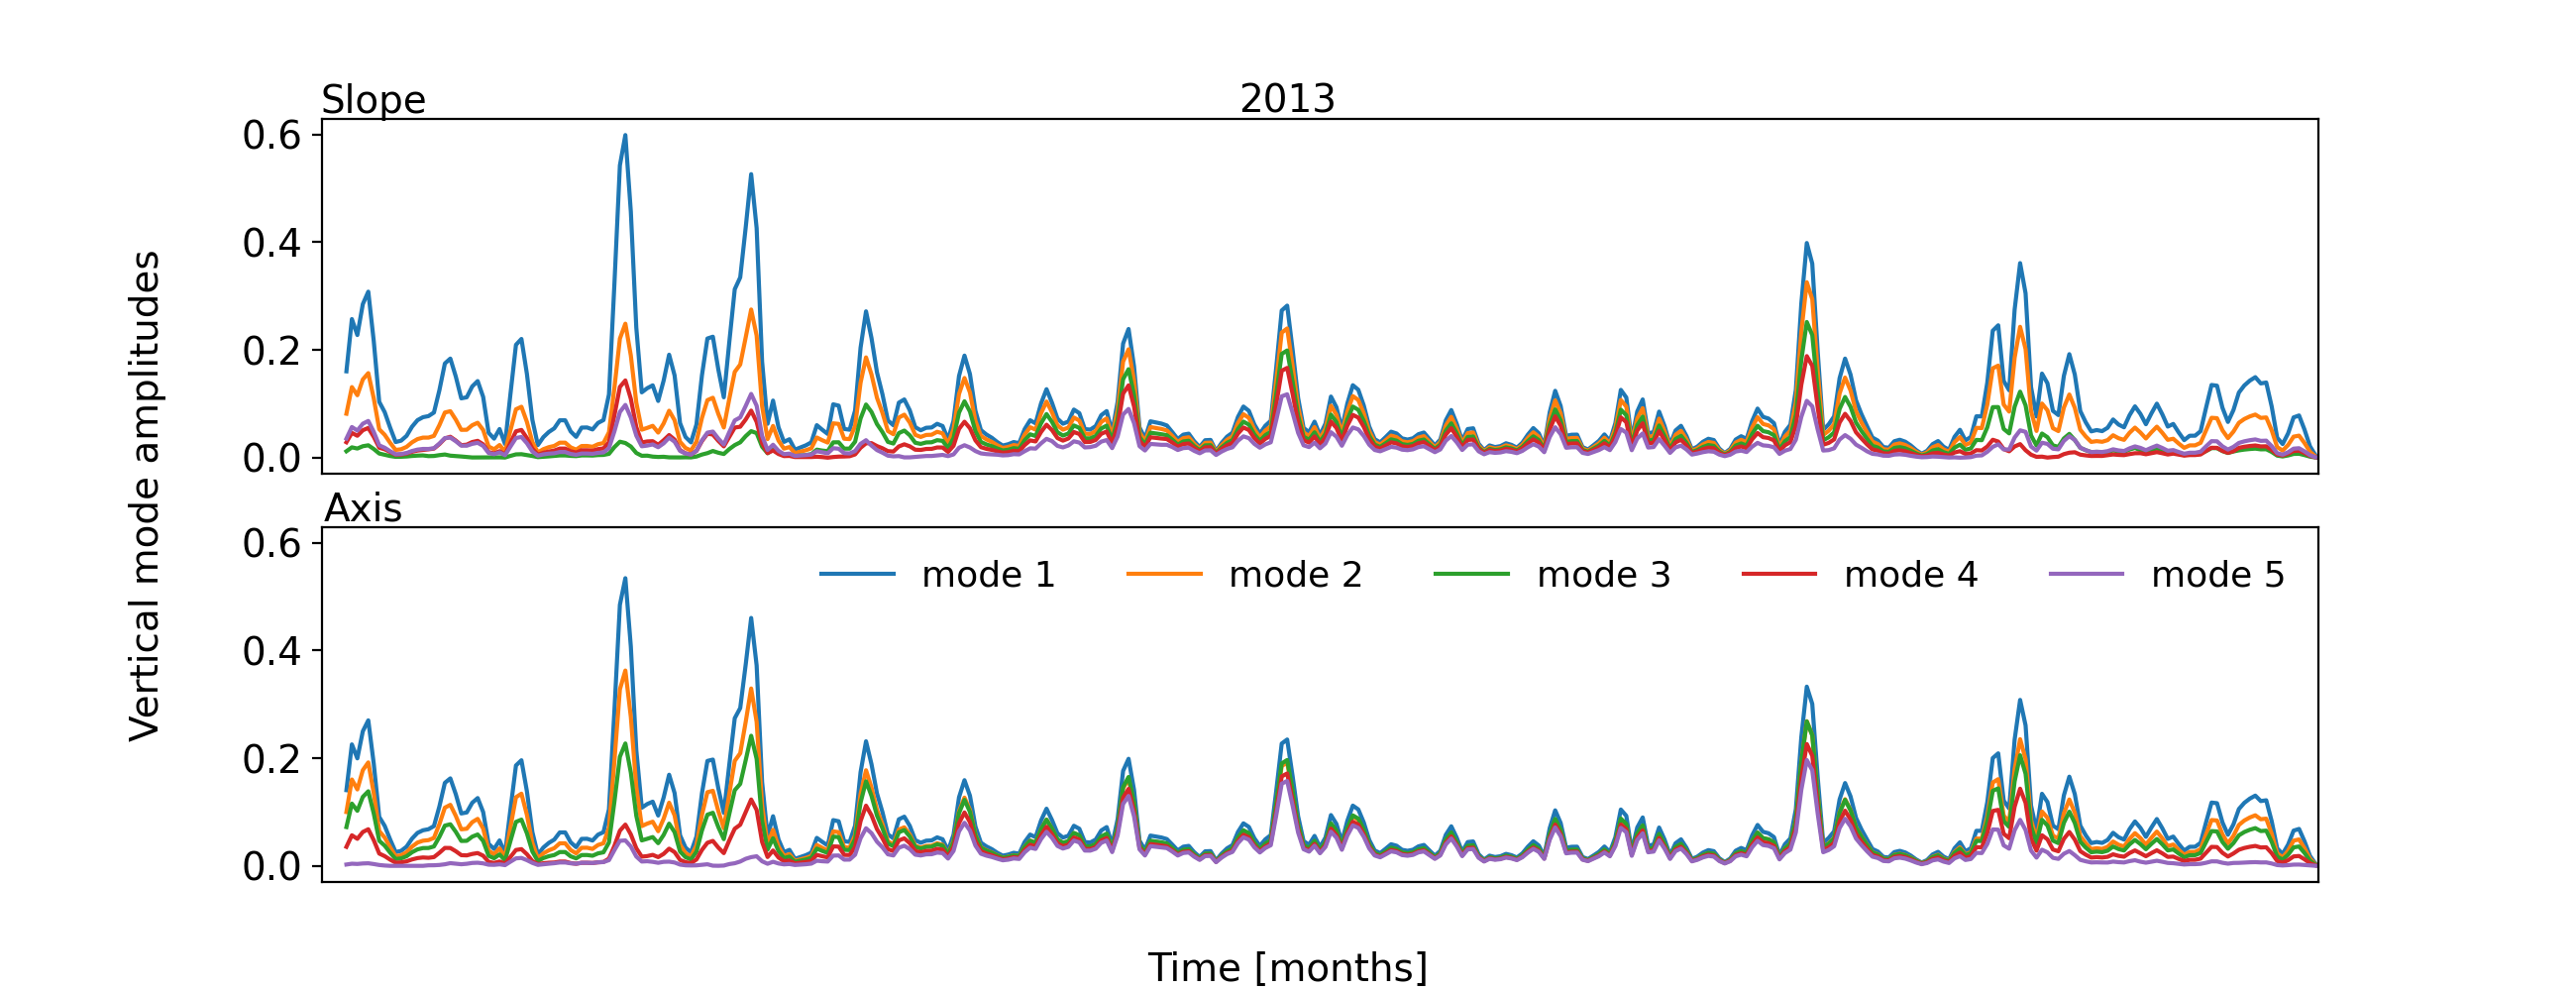

In [19]:
# plot modal amplitude data

fig,(ax,ax1) = plt.subplots(2,1,figsize=(13,5),sharey=True,sharex=True)
fig.subplots_adjust(hspace=0.15)
fig.text(0.5, 0.886, f'{t_stamp}', ha='center', fontsize=14)
fig.text(0.145, 0.886, f'{site}', ha='center', fontsize=14)
fig.text(0.141, 0.475, f'{site2}', ha='center', fontsize=14)
fig.text(0.5, 0.01, 'Time [months]', ha='center',fontsize=14) 
fig.text(0.05, 0.5, f'Vertical mode amplitudes',rotation='vertical',va='center',fontsize=14)
date_form = pldates.DateFormatter("%m")
for i in range(n_seg):
    if i == 0:
        ax.plot(Z1c[i].time,Z1c[i],label='mode 1',color='tab:blue')
        ax.plot(Z2c[i].time,Z2c[i],label='mode 2',color='tab:orange')
        ax.plot(Z3c[i].time,Z3c[i],label='mode 3',color='tab:green')
        ax.plot(Z4c[i].time,Z4c[i],label='mode 4',color='tab:red')
        ax.plot(Z5c[i].time,Z5c[i],label='mode 5',color='tab:purple')
        ax1.plot(Z1c2[i].time,Z1c2[i],label='mode 1',color='tab:blue')
        ax1.plot(Z2c2[i].time,Z2c2[i],label='mode 2',color='tab:orange')
        ax1.plot(Z3c2[i].time,Z3c2[i],label='mode 3',color='tab:green')
        ax1.plot(Z4c2[i].time,Z4c2[i],label='mode 4',color='tab:red')
        ax1.plot(Z5c2[i].time,Z5c2[i],label='mode 5',color='tab:purple')
    if i > 0:
        ax.plot(Z1c[i].time,Z1c[i],color='tab:blue')
        ax.plot(Z2c[i].time,Z2c[i],color='tab:orange')
        ax.plot(Z3c[i].time,Z3c[i],color='tab:green')
        ax.plot(Z4c[i].time,Z4c[i],color='tab:red')
        ax.plot(Z5c[i].time,Z5c[i],color='tab:purple')
        ax.plot(Z1c2[i].time,Z1c2[i],color='tab:blue')
        ax.plot(Z2c2[i].time,Z2c2[i],color='tab:orange')
        ax.plot(Z3c2[i].time,Z3c2[i],color='tab:green')
        ax.plot(Z4c2[i].time,Z4c2[i],color='tab:red')
        ax.plot(Z5c2[i].time,Z5c2[i],color='tab:purple')
    
ax.xaxis.set_major_formatter(date_form)
ax.set_xlim(start_date,end_date)
ax.tick_params(labelsize=14)
ax1.xaxis.set_major_formatter(date_form)
ax1.set_xlim(start_date,end_date)
ax1.tick_params(labelsize=14)
ax.axes.xaxis.set_ticks([])

ax1.legend(fontsize=13,ncol=5,loc='best',frameon=False)    
plt.show()

plt.savefig(fname=f'./mode_amps_{site}_{t_stamp}.pdf',format='pdf')

In [20]:
# rolling average wind data

coarsen_val = 360
wuc,wvc = [],[]
for i in range(n_seg_wind):
    wdir_deg = 270 - wdir[i]
    wdir_rad = np.radians(wdir_deg)
    wu = wspd[i]*np.cos(wdir_rad)        # u wind velocity vector
    wv = wspd[i]*np.sin(wdir_rad)        # v wind velocity vector
    if year == 2013:
        wucx = wu.rolling(dt2013=coarsen_val,center=True).mean().dropna('dt2013')
        wvcx = wv.rolling(dt2013=coarsen_val,center=True).mean().dropna('dt2013')
    elif year == 2014:
        wucx = wu.rolling(dt2014=coarsen_val,center=True).mean().dropna('dt2014')
        wvcx = wv.rolling(dt2014=coarsen_val,center=True).mean().dropna('dt2014')
    elif year == 2017:
        wucx = wu.rolling(dt2017=coarsen_val,center=True).mean().dropna('dt2017')
        wvcx = wv.rolling(dt2017=coarsen_val,center=True).mean().dropna('dt2017')
    elif year == 2018:
        wucx = wu.rolling(dt2018=coarsen_val,center=True).mean().dropna('dt2018')
        wvcx = wv.rolling(dt2018=coarsen_val,center=True).mean().dropna('dt2018')
    wuc.append(wucx / np.sqrt(wucx**2 + wvcx**2)) # this normalises the length of the arrows
    wvc.append(wvcx / np.sqrt(wucx**2 + wvcx**2))
    
wspdc,wdirc,wspdmax = [],[],[]
for i in range(n_seg_wind):
    ws = wspd[i]
    if year == 2013:
        wspdc.append(wspd[i].rolling(dt2013=coarsen_val,center=True).mean().dropna('dt2013'))
        wdirc.append(wdir[i].rolling(dt2013=coarsen_val,center=True).mean().dropna('dt2013'))
        wsx = ws.rolling(dt2013=50,center=True).max().dropna('dt2013')
    elif year == 2014:
        wspdc.append(wspd[i].rolling(dt2014=coarsen_val,center=True).mean().dropna('dt2014'))
        wdirc.append(wdir[i].rolling(dt2014=coarsen_val,center=True).mean().dropna('dt2014'))
    elif year == 2017:
        wspdc.append(wspd[i].rolling(dt2017=coarsen_val,center=True).mean().dropna('dt2017'))
        wdirc.append(wdir[i].rolling(dt2017=coarsen_val,center=True).mean().dropna('dt2017'))
    elif year == 2018:
        wspdc.append(wspd[i].rolling(dt2018=coarsen_val,center=True).mean().dropna('dt2018'))
        wdirc.append(wdir[i].rolling(dt2018=coarsen_val,center=True).mean().dropna('dt2018'))
    wspdmax.append(wsx)
    
# make quiver grid

x,xwspdmax,y = [],[],[]
for i in range(n_seg_wind):
    if year == 2013:
        xt = wuc[i].dt2013.values           # x coords
        xwspdmaxt = wspdmax[i].dt2013.values
    elif year == 2014:
        xt = wuc[i].dt2014.values           # x coords
    elif year == 2017:
        xt = wuc[i].dt2017.values           # x coords
    elif year == 2018:
        xt = wuc[i].dt2018.values           # x coords
    yt = np.zeros(len(xt))              # y coords
    x.append(xt)
    xwspdmax.append(xwspdmaxt)
    y.append(yt)

<IPython.core.display.Javascript object>


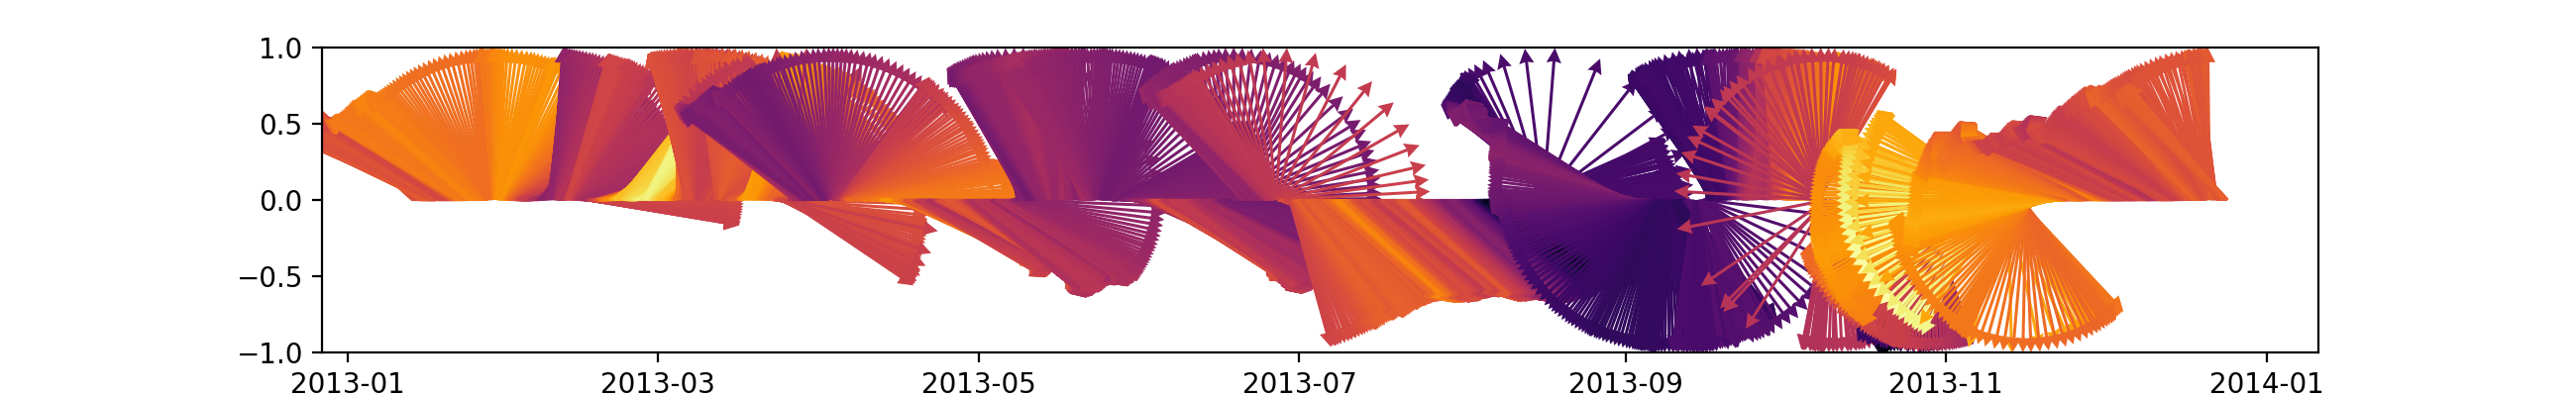

In [21]:
# plot wind vectors

fig,ax=plt.subplots(1,1,figsize=(13,2))
#ax.plot(wdir[0].dt2013,wdir[0])
#ax.plot(wdirc[0].dt2013,wdirc[0])
ccmap='inferno'
n = 1
for i in range(n_seg_wind):
    ax.quiver(x[i][::n],y[i][::n],wuc[i][::n],wvc[i][::n],wspdc[i][::n],angles='uv',scale_units='y',scale=1,width=0.0015,headwidth=5,cmap=ccmap)
ax.set_ylim(-1,1)
plt.show()

In [22]:
# get slab NI cw rotary data

# import data

ds_in = xr.open_dataset(f'../../../Data/wind/cw_inertial_{year}_0.nc')

n_seg_NI = ds_in.n_seg
if n_seg_NI > 1:
    dsNI = [ds_in]
    for i in range(n_seg_NI):
        if i > 0:
            dsNI_temp = xr.open_dataset(f'../../../Data/wind/cw_inertial_{year}_{i}.nc')
            dsNI.append(dsNI_temp)
elif n_seg_NI == 1:
    dsNI = [ds_in]

In [23]:
# get depthband NI cw rotary data

f_name = 'Inertial'     # do not change

ds_db,ds_db2 = [],[]

if year == 2013:
    if site == 'Slope':
        ds_db.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_{site}_2013_0.nc'))
        ds_db2.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis75_2013_0.nc'))
        ds_db2.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis75_2013_1.nc'))
    elif site == 'Axis':
        ds_db.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis75_2013_0.nc'))
        ds_db.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis75_2013_1.nc'))
        ds_db2.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Slope_2013_0.nc'))
if year == 2014:
    if site == 'Slope':
        ds_db.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_{site}_2014_0.nc'))
        ds_db2.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis75_2014_0.nc'))
        ds_db2.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis75_2014_1.nc'))
        ds_db2.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis75_2014_2.nc'))
    elif site == 'Axis':
        ds_db.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis75_2014_0.nc'))
        ds_db.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis75_2014_1.nc'))
        ds_db.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis75_2014_2.nc'))
        ds_db2.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Slope_2014_0.nc'))
if year == 2017:
    if site == 'Slope':
        ds_db.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_{site}_2017_0.nc'))
        ds_db.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_{site}_2017_1.nc'))
        ds_db2.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis55_2017_0.nc'))
        ds_db2.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis55_2017_1.nc'))
    elif site == 'Axis':
        ds_db.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis55_2017_0.nc'))
        ds_db.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis55_2017_1.nc'))
        ds_db2.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Slope_2017_0.nc'))
        ds_db2.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Slope_2017_1.nc'))
if year == 2018:
    if site == 'Slope':
        ds_db.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_{site}_2018_0.nc'))
        ds_db2.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis55_2018_0.nc'))
        ds_db2.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis55_2018_1.nc'))
        ds_db2.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis55_2018_2.nc'))
        ds_db2.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis55_2018_3.nc'))
    elif site == 'Axis':
        ds_db.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis55_2018_0.nc'))
        ds_db.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis55_2018_1.nc'))
        ds_db.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis55_2018_2.nc'))
        ds_db.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Axis55_2018_3.nc'))
        ds_db2.append(xr.open_dataset(f'../../../Data/interannual/depthband_rot_{f_name}_Slope_2018_0.nc'))

<IPython.core.display.Javascript object>


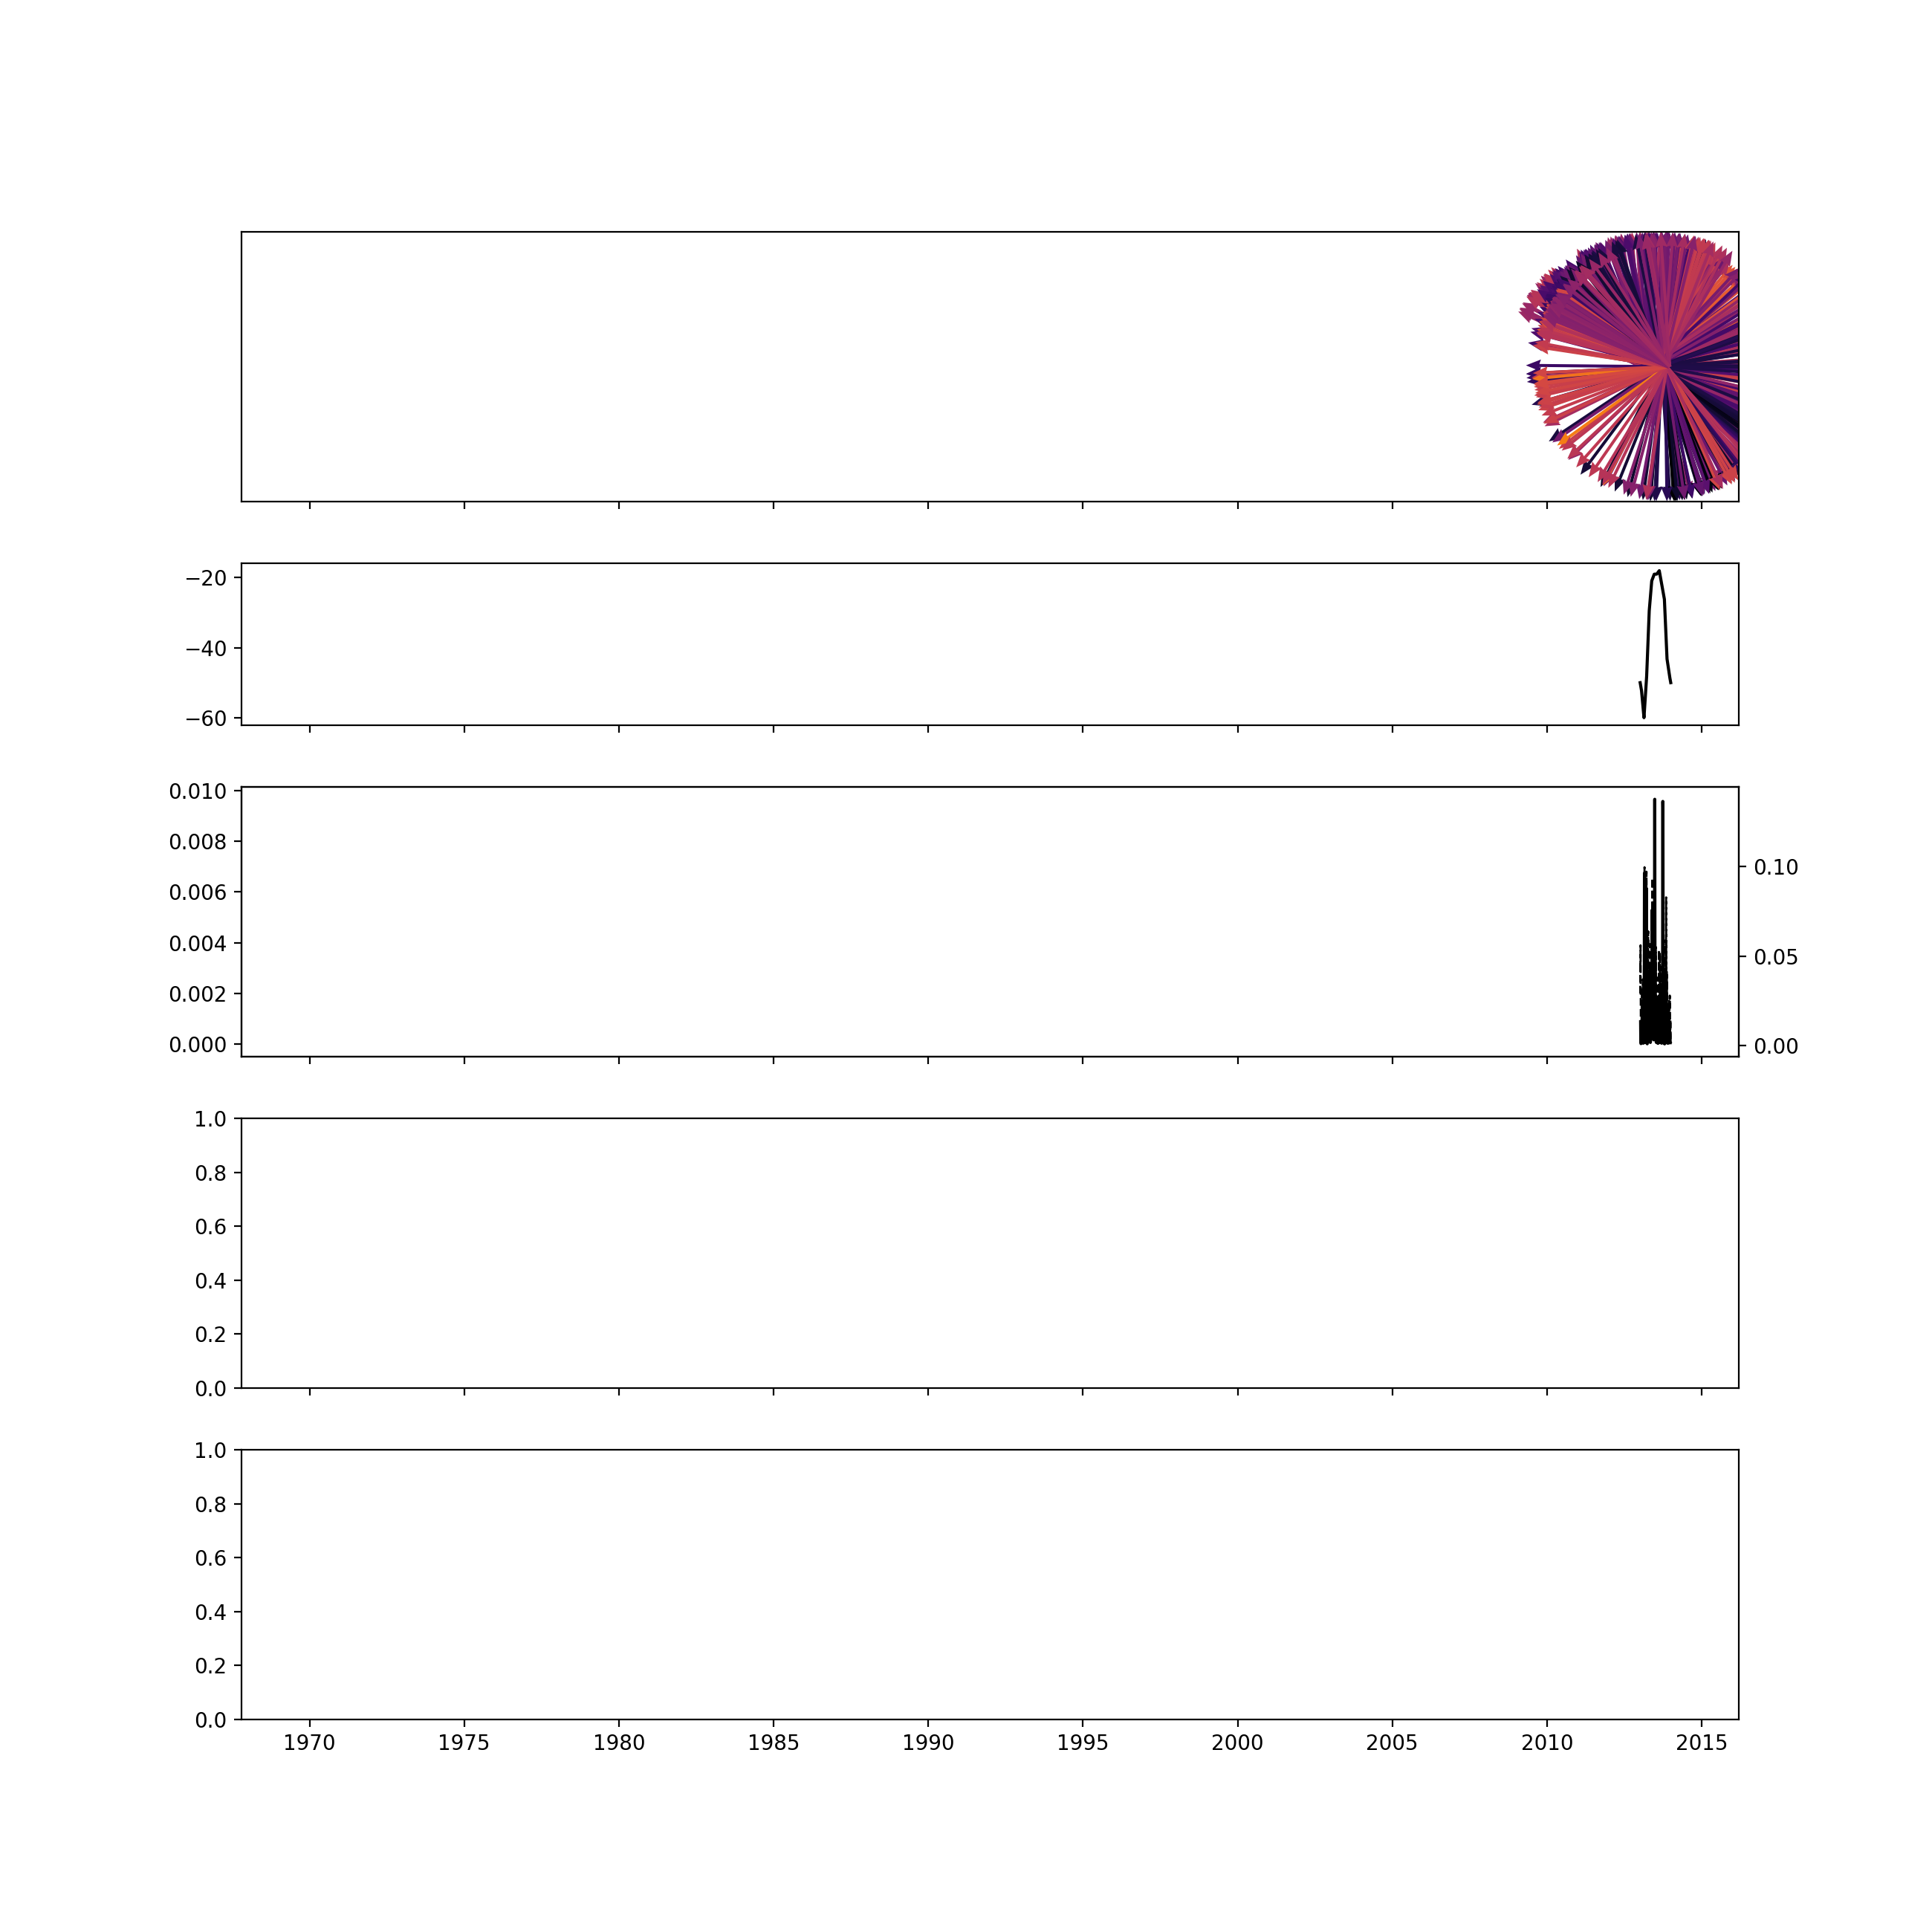

UFuncTypeError: Cannot cast ufunc 'greater_equal' input 0 from dtype('<m8[ns]') to dtype('<m8') with casting rule 'same_kind'

In [25]:
# plot NI data (use Slope as 'site')

fig,(ax0,ax1,ax2,ax5,ax6) = plt.subplots(5,1,figsize=(13,13),sharex=True,gridspec_kw={'height_ratios': [1, 0.6, 1, 1, 1]})
fig.subplots_adjust(hspace=0.25)
date_form = pldates.DateFormatter("%m")
    
ccmap='inferno'
n = 10
cnorm = matplotlib.colors.Normalize(vmin=3,vmax=10,clip=False)
for i in range(n_seg_wind):
    im0 = ax0.quiver(x[i][::n],y[i][::n],wuc[i][::n],wvc[i][::n],wspdc[i][::n],angles='uv',scale_units='y',scale=1,\
                     width=0.002,headwidth=4,cmap=ccmap,norm=cnorm)
ax0.set_ylim(-1,1) 
ax0.axes.yaxis.set_ticks([])

for i in range(n_seg):
    ax1.plot(time[i],-mld[i],color='black')

for i in range(dsNI[0].n_seg):
    if i == 0:
        ax2.plot(dsNI[i].time,dsNI[i].cw,color='black',label='CW power')
        ax2.plot([0,0],[0,0],color='black',ls='--',lw=1,label='Currents')
    elif i > 0:
        ax2.plot(dsNI[i].time,dsNI[i].cw,color='black')
        ax2.plot([0,0],[0,0],color='black',ls='--',lw=1)
ax2x = ax2.twinx() 
for i in range(n_seg):
    ax2x.plot(Ufc[i].time,Ufc[i],color='black',ls='--',lw=1,label='Currents')    

if site == 'Slope':
    vmin = 1e-4
    vmax = 5e-3
    site2 = 'Axis'
    vmin2 = 1e-4
    vmax2 = 5e-3  
for i in range(ds_db[0].n_seg):
    im5 = ax5.pcolormesh(ds_db[i].spect_s, -ds_db[i].depth, ds_db[i].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
    ax5.xaxis.set_major_formatter(date_form)
fig.subplots_adjust(right=0.9)
# cbar_ax5 = fig.add_axes([0.905, 0.21, 0.01, 0.16])
# cbar5 = fig.colorbar(im5, cax=cbar_ax5, fraction=0.05, pad=0.01, aspect=15, extend='both')
# cbar5.ax.tick_params(labelsize=14)    

for i in range(ds_db2[0].n_seg):
    im6 = ax6.pcolormesh(ds_db2[i].spect_s, -ds_db2[i].depth, ds_db2[i].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin2, vmax=vmax2), cmap='plasma', shading='auto')  
    ax6.xaxis.set_major_formatter(date_form)
cbar_ax6 = fig.add_axes([0.905, 0.11, 0.01, 0.214])
cbar6 = fig.colorbar(im6, cax=cbar_ax6, fraction=0.05, pad=0.01, aspect=15, extend='both')
cbar6.ax.tick_params(labelsize=14) 

cbar_ax0 = fig.add_axes([0.905, 0.784, 0.01, 0.096])
cbar0 = fig.colorbar(im0, cax=cbar_ax0, fraction=0.05, pad=0.01, aspect=15, extend='neither')
cbar0.ax.tick_params(labelsize=14) 
    
fig.text(0.51, 0.885, f'{t_stamp}', ha='center', fontsize=14)
fig.text(0.124, 0.885, f'Wind', fontsize=14)
fig.text(0.124, 0.765, f'Mixed-layer depth', fontsize=14)
fig.text(0.124, 0.685, f'Slab NI CW power',fontsize=14)
fig.text(0.78, 0.685, f'Slab NI currents',fontsize=14)
fig.text(0.124, 0.566, f'{site} modal decomposition',fontsize=14)
fig.text(0.124, 0.448, f'{site2} modal decomposition',fontsize=14)
fig.text(0.124, 0.329, f'{site} NI CW power',fontsize=14)
fig.text(0.124, 0.21, f'{site2} NI CW power',fontsize=14)
fig.text(0.813, 0.329, f'WKB-scaled',fontsize=14)
fig.text(0.062, 0.735, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.1, 0.83, r'Direction [$\degree$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.965, 0.83, 'Magnitude [m/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.045, 0.63, r'Power [(m/s)$^2$]', va='center', rotation='vertical',fontsize=14)
fig.text(0.955, 0.63, 'Magnitude [m/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.05, 0.46, 'Amplitude [m/s]', va='center', rotation='vertical',fontsize=14)
fig.text(0.97, 0.218, r'Rotary PSD [(m/s)$^2$/Hz]', va='center', rotation='vertical',fontsize=14)
fig.text(0.05, 0.218, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.07, 'Time [months]', ha='center',fontsize=14) 

axs = [ax0,ax1,ax2,ax2x,ax5,ax6]
for i in axs:
    i.xaxis.set_major_formatter(date_form)
    i.set_xlim(start_date,end_date)
    i.tick_params(labelsize=14)

ax2.set_ylim(-0.0002,0.01)
ax2x.set_ylim(-0.001,0.15)
ax6.set_ylim(-ds_db2[0].depth[-1],-650)

colour = 'darkgrey'
ax5.patch.set_facecolor(colour)
ax6.patch.set_facecolor(colour)
ax0.patch.set_facecolor(colour)
ax2.legend(loc='best',fontsize=12,frameon=False)

plt.show()

# plt.savefig(fname=f'./NI_comparison_{t_stamp}.pdf',format='pdf')

<IPython.core.display.Javascript object>


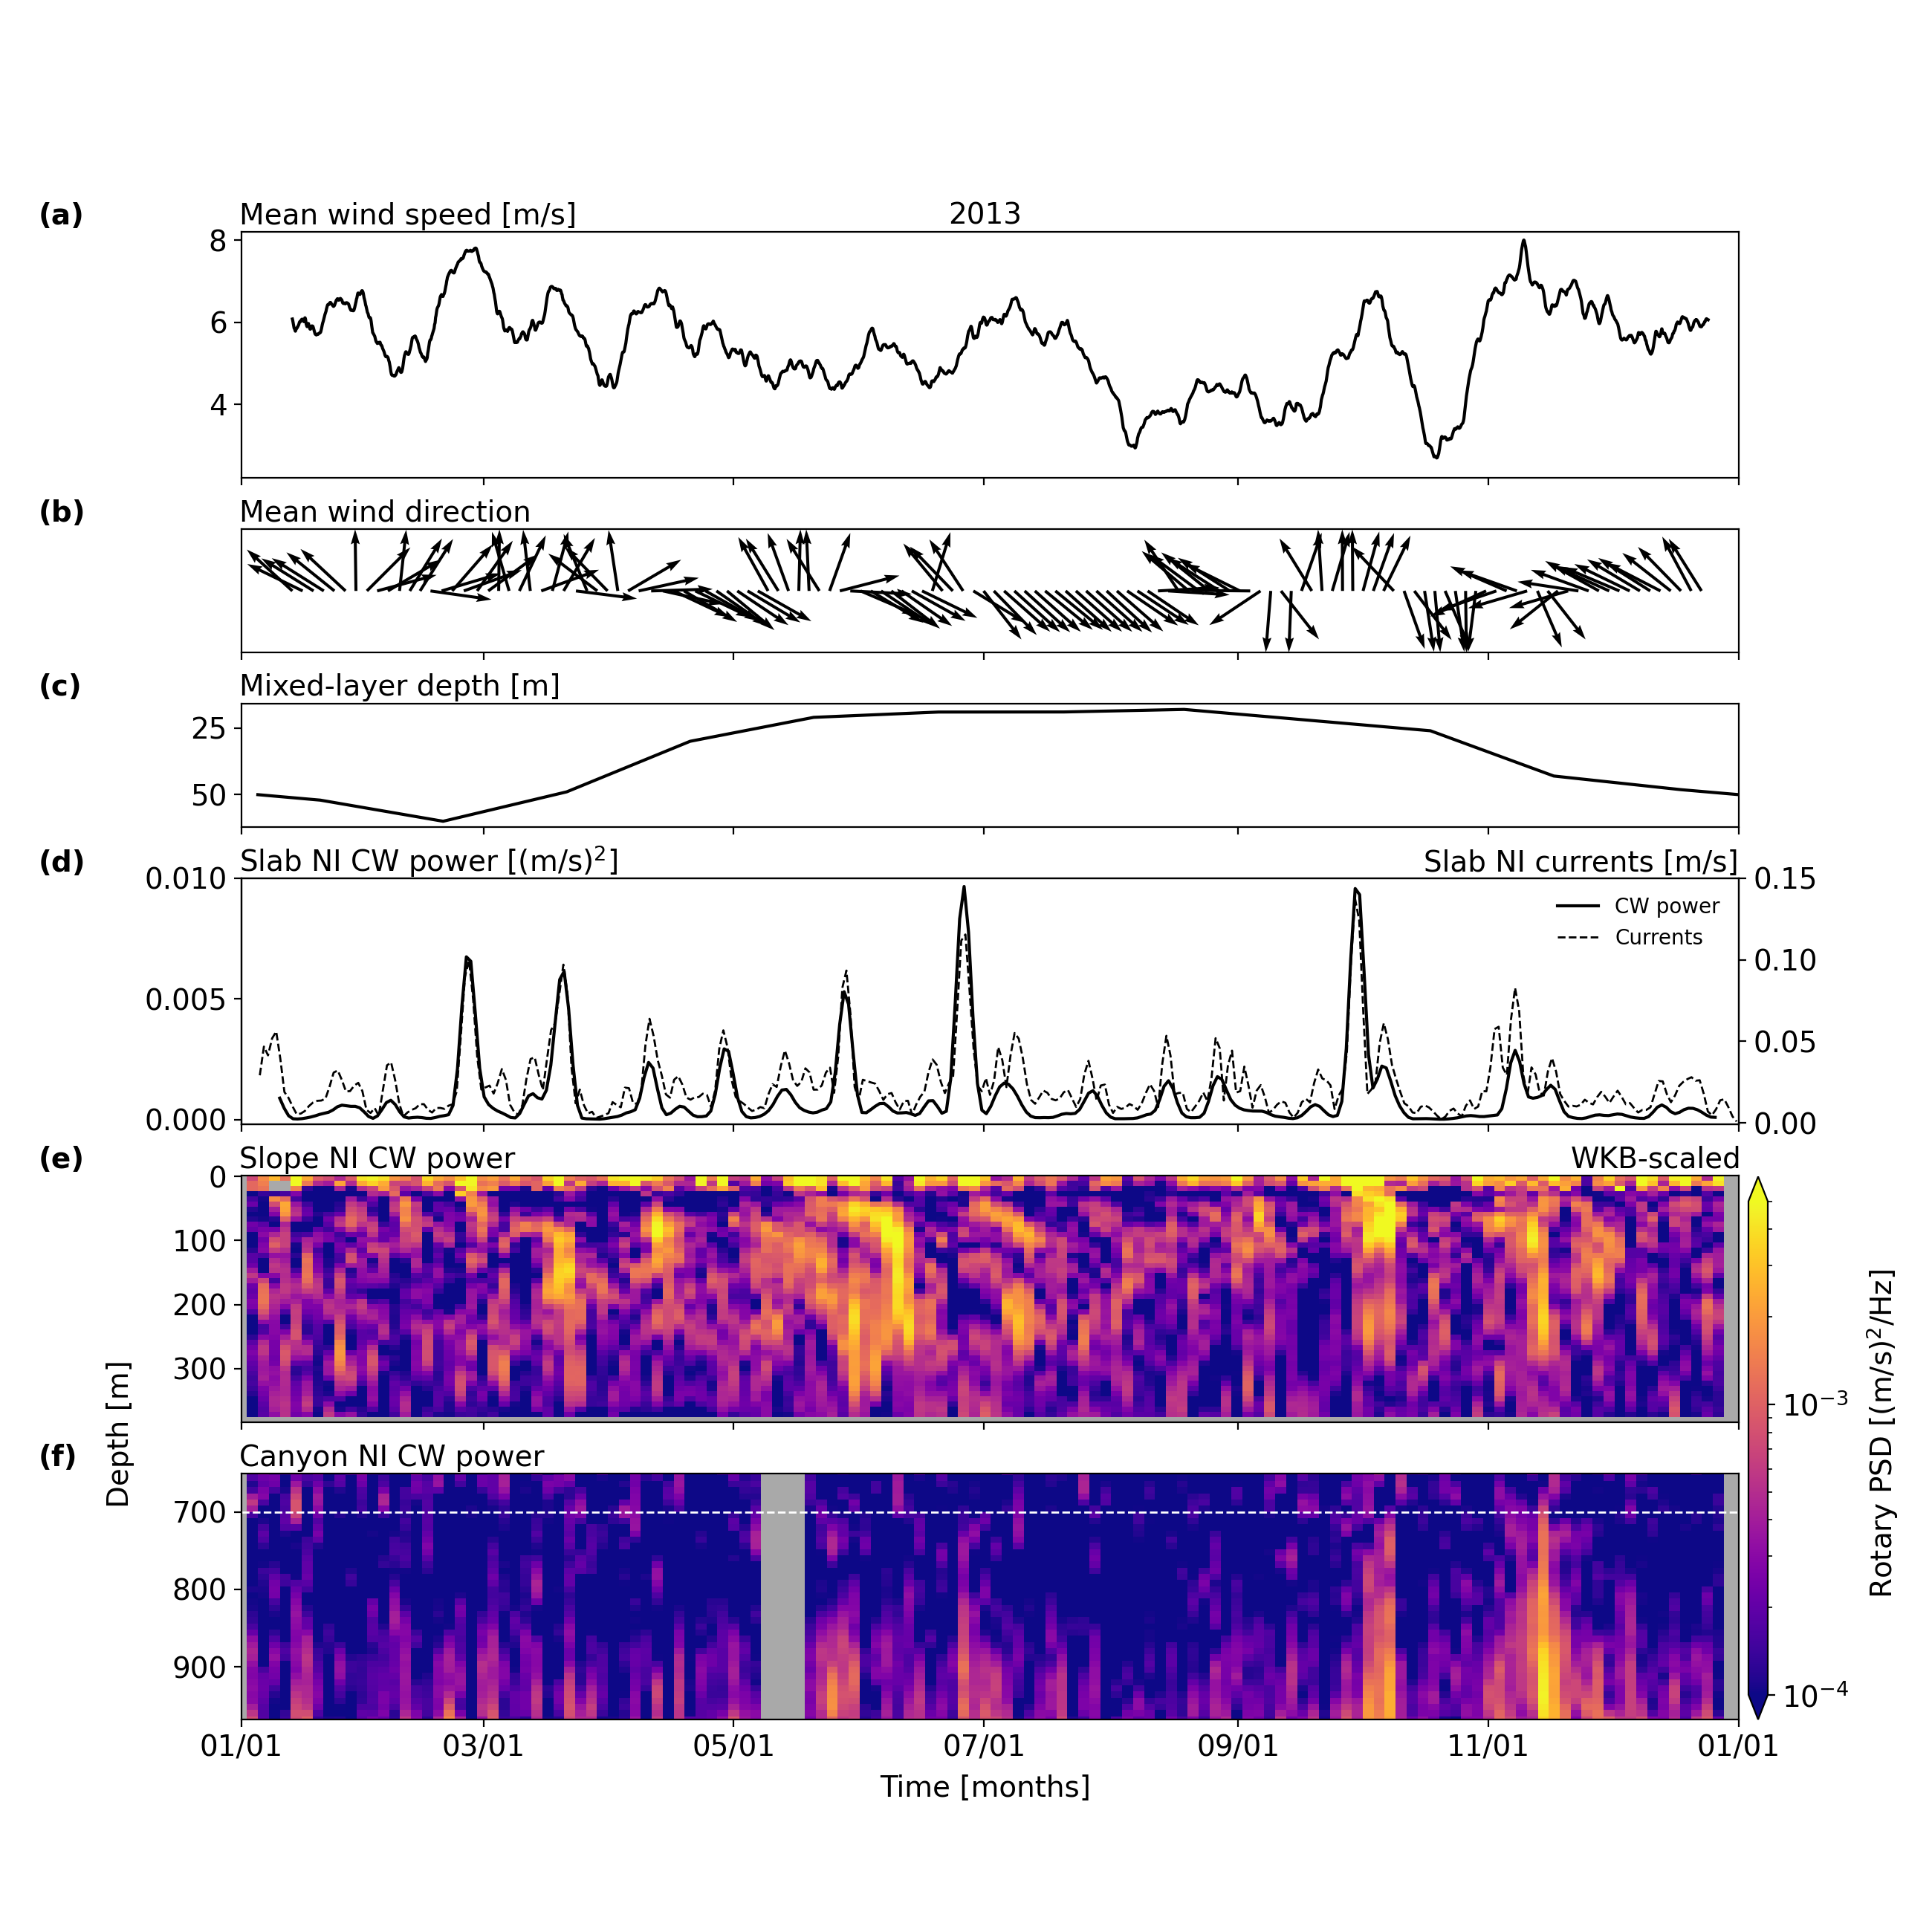

In [27]:
# revised figure for JGR

fig,(ax0,ax1,ax2,ax3,ax4,ax5) = plt.subplots(6,1,figsize=(13,13),sharex=True,gridspec_kw={'height_ratios': [1,0.5,0.5,1,1,1]})
fig.subplots_adjust(hspace=0.25)

ax0.plot(x[0],wspdc[0],color='k')
#ax0.scatter(xwspdmax[0],wspdmax[0],color='k')
ax0.set_ylim(2.2,8.2)
date_form = pldates.DateFormatter("%m/%d")
ax0.xaxis.set_major_formatter(date_form)

n = 60
im1 = ax1.quiver(x[0][::n],y[0][::n],wuc[0][::n],wvc[0][::n],angles='uv',width=0.002,headwidth=3,cmap=ccmap, scale_units='y', scale=1)
ax1.set_ylim(-1,1) 
ax1.axes.yaxis.set_ticks([])

ax2.plot(time[0],-mld[0],color='black')
ax2.set_yticks([-50,-25])
ax2.set_yticklabels([50,25])

ax3.plot(dsNI[0].time,dsNI[0].cw,color='black',label='CW power')
ax3.plot([np.datetime64('2013-12-09'),np.datetime64('2013-12-09')],[0,0],color='black',ls='--',lw=1,label='Currents')
ax3x = ax3.twinx() 
ax3x.plot(Ufc[0].time,Ufc[0],color='black',ls='--',lw=1,label='Currents')
ax3.legend(frameon=False)
ax3.set_ylim(-0.0002,0.01)
ax3x.set_ylim(-0.001,0.15)
    
if site == 'Slope':
    vmin = 1e-4
    vmax = 5e-3
    site2 = 'Canyon' 

im4 = ax4.pcolormesh(ds_db[0].spect_s.values, -ds_db[0].depth, ds_db[0].cw_WKB, rasterized=True, cmap='plasma', shading='auto', \
                    norm=colors.LogNorm(vmin=vmin, vmax=vmax))  
fig.subplots_adjust(right=0.9)
colour = 'darkgrey'
ax4.patch.set_facecolor(colour)
ax4.set_yticks([-300,-200,-100,0])
ax4.set_yticklabels([300,200,100,0])

for i in range(ds_db2[0].n_seg):
    im5 = ax5.pcolormesh(ds_db2[i].spect_s.values, -ds_db2[i].depth, ds_db2[i].cw_WKB, rasterized=True, \
                norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='plasma', shading='auto')  
    ax5.xaxis.set_major_formatter(date_form)
cbar_ax5 = fig.add_axes([0.905, 0.11, 0.01, 0.281])
cbar5 = fig.colorbar(im5, cax=cbar_ax5, fraction=0.08, pad=0.01, aspect=40, extend='both')
cbar5.ax.tick_params(labelsize=14) 
ax5.set_ylim(-ds_db2[0].depth[-1],-650)
ax5.patch.set_facecolor(colour)
ax5.set_yticks([-900,-800,-700])
ax5.set_yticklabels([900,800,700])
ax5.hlines(y=-700, xmin=start_date,xmax=end_date, linewidth=1, color='white', ls='--')


axs = [ax0,ax1,ax2,ax3,ax3x,ax4,ax5]
for i in axs:
    i.xaxis.set_major_formatter(date_form)
    i.set_xlim(start_date,end_date)
    i.set_xlim()
    i.tick_params(labelsize=14)
    
fig.text(0.51, 0.884, f'{t_stamp}', ha='center', fontsize=14)
fig.text(0.124, 0.884, 'Mean wind speed [m/s]', fontsize=14)
fig.text(0.124, 0.730, 'Mean wind direction', fontsize=14)
fig.text(0.124, 0.640, 'Mixed-layer depth [m]', fontsize=14)
fig.text(0.124, 0.549, r'Slab NI CW power [(m/s)$^2$]',fontsize=14)
fig.text(0.90, 0.549, r'Slab NI currents [m/s]',fontsize=14, ha='right')
fig.text(0.124, 0.3955, f'{site} NI CW power',fontsize=14)
fig.text(0.124, 0.241, f'{site2} NI CW power',fontsize=14)
fig.text(0.813, 0.3955, f'WKB-scaled',fontsize=14)
fig.text(0.965, 0.258, r'Rotary PSD [(m/s)$^2$/Hz]', va='center', rotation='vertical',fontsize=14)
fig.text(0.055, 0.258, 'Depth [m]', va='center', rotation='vertical',fontsize=14)
fig.text(0.51, 0.07, 'Time [months]', ha='center',fontsize=14) 
fig.text(0.02, 0.884, '(a)', ha='left',fontsize=14, fontweight='bold') 
fig.text(0.02, 0.730, '(b)', ha='left',fontsize=14, fontweight='bold') 
fig.text(0.02, 0.640, '(c)', ha='left',fontsize=14, fontweight='bold') 
fig.text(0.02, 0.549, '(d)', ha='left',fontsize=14, fontweight='bold') 
fig.text(0.02, 0.3955, '(e)', ha='left',fontsize=14, fontweight='bold') 
fig.text(0.02, 0.241, '(f)', ha='left',fontsize=14, fontweight='bold') 

plt.show()

plt.savefig(fname=f'./NI_comparison_{t_stamp}.pdf',format='pdf')